#### Import libraries

In [2]:
import pandas as pd
import numpy as np

import datetime

In [3]:
today = datetime.datetime.today()
today = today.strftime('%Y-%m-%d')

print("Today is " + str(today))

Today is 2025-02-02


#### Import data
Source: https://www.nasdaq.com/market-activity/stocks/msft/historical

In [5]:
data = pd.read_csv("processed_data.csv")

In [6]:
data.rename(columns={"Unnamed: 0":"Date"}, inplace=True)

In [7]:
data.set_index("Date", inplace=True)
data.index = pd.to_datetime(data.index)

In [8]:
data.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-18,28.9787,27351.0,29.09,29.09,28.94
2019-12-19,29.1600,18240.0,28.97,29.17,28.97
2019-12-20,29.4200,38043.0,29.37,29.44,29.26
2019-12-21,29.4200,38043.0,29.37,29.44,29.26
2019-12-22,29.4200,38043.0,29.37,29.44,29.26


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2019-12-18 to 2024-12-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1827 non-null   float64
 1   Volume  1827 non-null   float64
 2   Open    1827 non-null   float64
 3   High    1827 non-null   float64
 4   Low     1827 non-null   float64
dtypes: float64(5)
memory usage: 85.6 KB


#### Date Range For Modeling

In [11]:
model_data = data["Close"].loc["2023-01-01":"2024-11-30"]

#### Test & Train Split

In [13]:
# Set training and testing sizes
train_size = int(len(model_data) * 0.90)

train, test = model_data[0:train_size], model_data[train_size:len(data)]

#### Visualizations

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

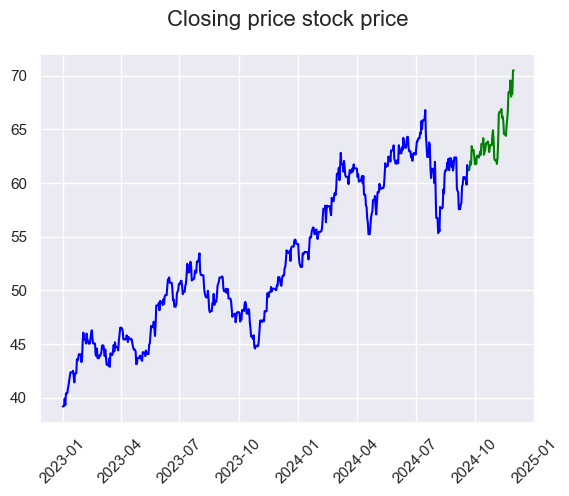

In [16]:
plt.plot(train, color="blue", label="Train Split")
plt.plot(test, color="green", label="Test Split")
plt.title("Closing price stock price", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.show()

#### ADF Test for Stationality

In [18]:
# Import Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [19]:
# ADF Test No Difference
adf_test = adfuller(train)
print(f"p-value: {adf_test[1]}")

p-value: 0.4703475325587958


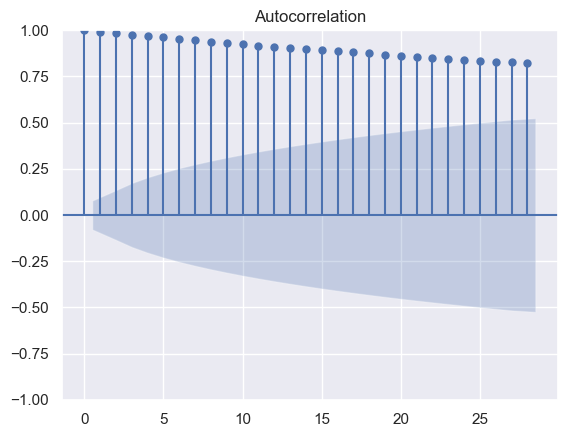

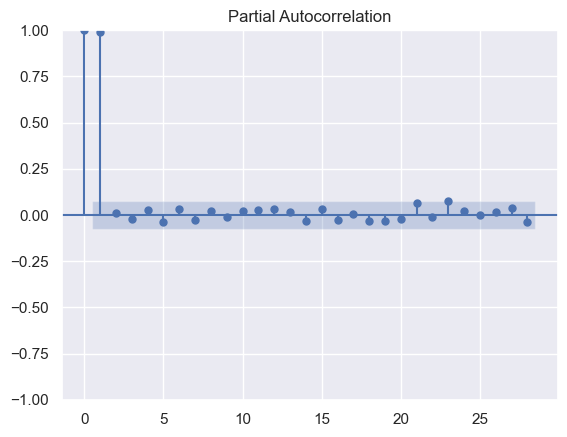

In [20]:
# Plot ACF and PCF
plot_acf(train)
plot_pacf(train)
plt.show()

<Axes: xlabel='Date'>

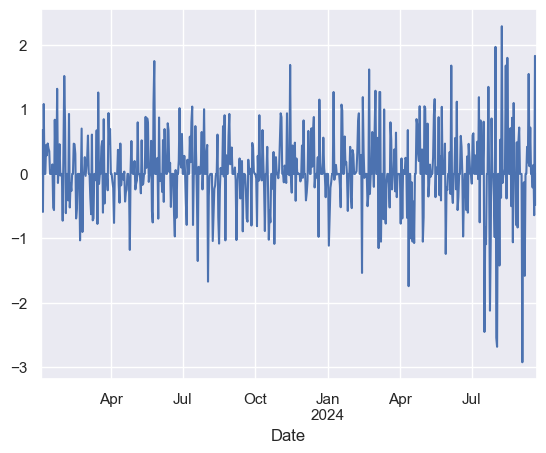

In [21]:
# ADF Test With Differencing in first order
train_df_diff = train.diff().dropna()
train_df_diff.plot()

In [22]:
# ADF Test With Differencing in first order
adf_test_diff = adfuller(train_df_diff)
print(f"p-value: {adf_test_diff[1]}")

p-value: 0.0


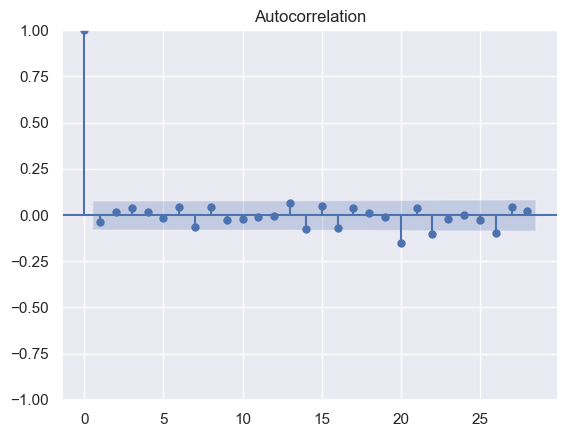

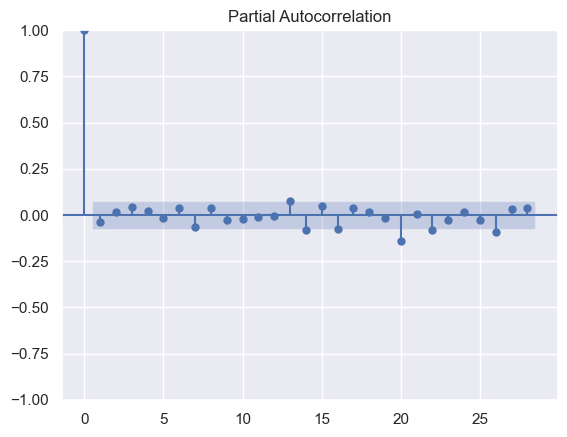

In [23]:
plot_acf(train_df_diff)
plot_pacf(train_df_diff)
plt.show()

#### Time Series Model

In [25]:
model = ARIMA(train, order=(0,1,0), freq="D")
model_fit = model.fit()
model_fit.summary()

C:\Users\jac67\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  630
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -564.781
Date:                Sun, 02 Feb 2025   AIC                           1131.562
Time:                        16:55:33   BIC                           1136.006
Sample:                    01-01-2023   HQIC                          1133.288
                         - 09-21-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3527      0.012     28.660      0.000       0.329       0.377
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):               301.19
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Residuals Plot

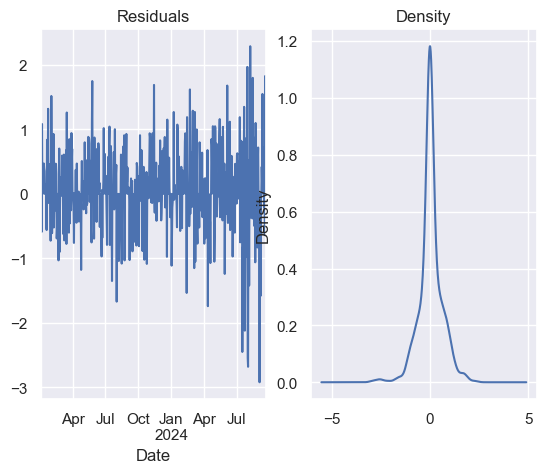

In [27]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind="kde", ax=ax[1])
plt.show()

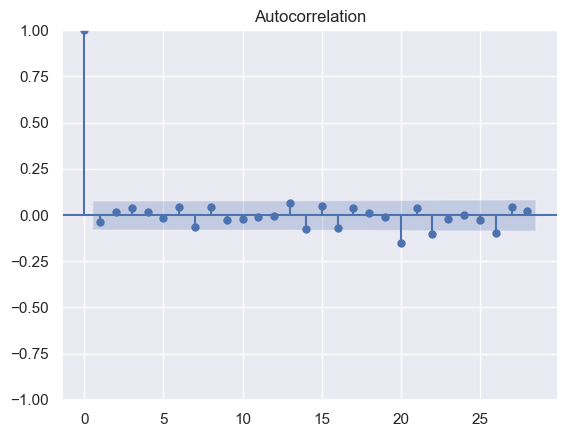

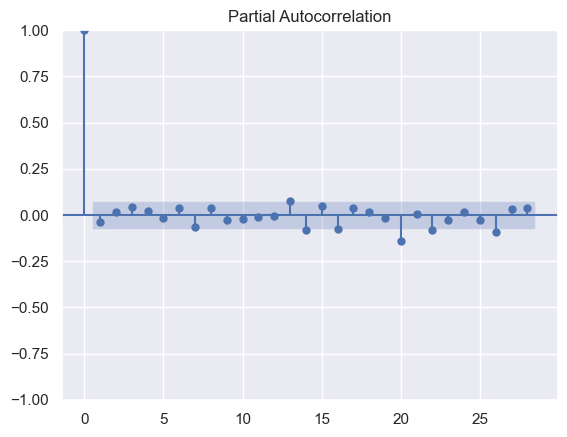

In [28]:
# ACF and PACF plots of Residuals
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

#### Forecast On Testing Data With Model

In [30]:
forecast = model_fit.forecast(steps=len(test))

In [31]:
# Compare Test Data with Forecast Data
comparison = pd.DataFrame()
comparison["Test"] = test.round(2)
comparison["Forecast"] = forecast.round(2)
comparison.head()

,Test,Forecast
Date,,
2024-09-22,61.19,61.19
2024-09-23,61.50,61.19
2024-09-24,62.02,61.19
2024-09-25,61.72,61.19
2024-09-26,63.44,61.19


#### Analyze Model Performance

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)
rsme = mean_squared_error(test, forecast)

print("Mean Absolute Error =", round(mae, 3))
print("Mean Absolute Percentage Error =", round(mape, 3))
print("Mean Squared Error =", round(rsme, 3))

Mean Absolute Error = 3.128
Mean Absolute Percentage Error = 0.047
Mean Squared Error = 15.05


In [34]:
# Ratio of RSME to mean of model data inputs
ratio = rsme / np.mean(model_data)

if ratio >= 0.05:
    print("There is likely medium to high error in this model. Ratio is", f"{ratio:.1%}")
else:
    print("There is likely low error in this model, as the ratio of RSME to mean of input values is", f"{ratio:.1%}")

There is likely medium to high error in this model. Ratio is 27.9%


#### Predict Future Prices

In [36]:
predicton_steps = 30
start_index = len(train) + len(test)
end_index = start_index + predicton_steps

predictions = model_fit.predict(start = start_index, end=end_index)

In [37]:
# View last five rows of future predictions
predictions.tail(15).round(2)

2024-12-17    61.19
2024-12-18    61.19
2024-12-19    61.19
2024-12-20    61.19
2024-12-21    61.19
2024-12-22    61.19
2024-12-23    61.19
2024-12-24    61.19
2024-12-25    61.19
2024-12-26    61.19
2024-12-27    61.19
2024-12-28    61.19
2024-12-29    61.19
2024-12-30    61.19
2024-12-31    61.19
Freq: D, Name: predicted_mean, dtype: float64

#### Plot Test, Train, and Forecast

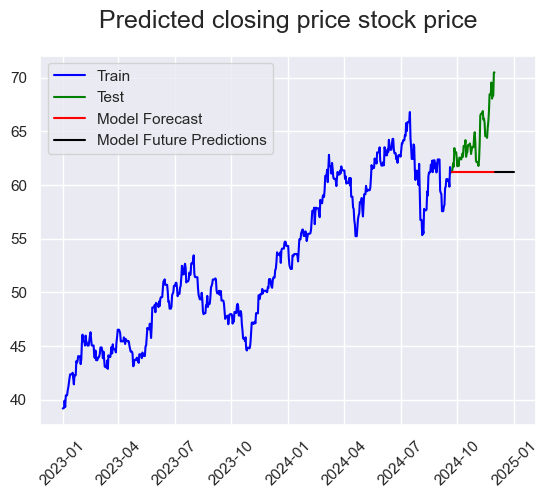

In [39]:
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="green")
plt.plot(forecast, label="Model Forecast", color="red")
plt.plot(predictions, label="Model Future Predictions", color="black")
plt.title("Predicted closing price stock price", fontsize=18, pad=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()